In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dictionary_new import category_product_dictionary
df = pd.read_csv("C:/Users/Pc_User/Desktop/H-Farm/survey_hfarm_1.csv")
df = df[df['Status'] == 'IP Address'].reset_index(drop=True)

## Data cleaning

In [2]:
df.columns.values

array(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Q9', 'Q6', 'Q1_1', 'Q1_2',
       'Q1_3', 'Q1_4', 'Q1_5', 'Q1_6', 'Q1_7', 'Q1_8', 'Q1_9', 'Q14_1',
       'Q15_1', 'Q4', 'Q11', 'Q12_1', 'Q13', 'Q7_1'], dtype=object)

In [3]:
questions_n = ['Q9', 'Q6', 'Q1_1', 'Q1_2', 'Q1_3', 'Q1_4', 'Q1_5', 'Q1_6', 'Q1_7', 'Q1_8', 'Q1_9', 'Q14_1',
             'Q15_1', 'Q4', 'Q11', 'Q12_1', 'Q13', 'Q7_1']
questions = ['Gender', 'Age', 'Fruit', 'Vegetable', 'Red meat','Fish','Egg','Snacks','Junk',
             'Ready to eat/drink','Alcohol', 'Subjective health', 'Contains plastic', 'Chocolate box?', 'Optimistic', 
            'Level of concern', 'Longevity insurance', 'Cash inflow']
assert len(questions_n) == len(questions)

In [4]:
df = df[questions_n]

In [5]:
df.rename(dict(zip(questions_n, questions)), inplace=True, axis=1)

In [6]:
df.head(5)

,Gender,Age,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Subjective health,Contains plastic,Chocolate box?,Optimistic,Level of concern,Longevity insurance,Cash inflow
0,Female,18 - 24,4,2,5,4,5,5,1,1,3,4,4,The best one,More than 80 years,5,No,1500
1,Male,18 - 24,5,5,3,2,2,1,1,2,1,5,3,The best one,More than 80 years,5,Yes,700
2,Female,18 - 24,5,4,3,4,1,1,1,2,1,4,5,The best one,Less than 80 years,3,Yes,0
3,Male,25 - 34,5,4,4,2,5,5,3,3,3,3,3,The best one,More than 80 years,4,No,6000
4,I prefer not to specify,18 - 24,2,2,3,2,3,2,2,2,5,3,3,The best one,Less than 80 years,NaN,No,0


### Convert to numerical variables

In [7]:
numeric = ['Fruit', 'Vegetable', 'Red meat','Fish','Egg','Snacks','Junk',
             'Ready to eat/drink','Alcohol', 'Subjective health', 'Contains plastic', 'Level of concern', 'Cash inflow'] 

for num in numeric:
    df[num] = pd.to_numeric(df[num], errors='coerce')

### Swap environemental friendliness with unfriendliness (to match contains plastic)

In [8]:
df['Contains plastic'] = (df['Contains plastic'] - 6) * -1

In [9]:
print(len(df))
df.head(5)

115


,Gender,Age,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Subjective health,Contains plastic,Chocolate box?,Optimistic,Level of concern,Longevity insurance,Cash inflow
0,Female,18 - 24,4,2,5,4,5,5,1,1,3,4.0,2.0,The best one,More than 80 years,5.0,No,1500.0
1,Male,18 - 24,5,5,3,2,2,1,1,2,1,5.0,3.0,The best one,More than 80 years,5.0,Yes,700.0
2,Female,18 - 24,5,4,3,4,1,1,1,2,1,4.0,1.0,The best one,Less than 80 years,3.0,Yes,0.0
3,Male,25 - 34,5,4,4,2,5,5,3,3,3,3.0,3.0,The best one,More than 80 years,4.0,No,6000.0
4,I prefer not to specify,18 - 24,2,2,3,2,3,2,2,2,5,3.0,3.0,The best one,Less than 80 years,NaN,No,0.0


### Transform to numerical

In [10]:
df['Longevity insurance'].replace({'No': 0, 'Yes': 1}, inplace=True)
df['Chocolate box?'].replace({'The worst one': 0, 'The best one': 1}, inplace=True)
df['Optimistic'].replace({'Less than 80 years': 0, 'More than 80 years': 1}, inplace=True)
df['Male'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df.drop(['Gender'], axis=1, inplace=True)


In [11]:
age_groups = [list(np.unique(df['Age']))[-1]] + list(np.unique(df['Age']))[0:-1] 

In [12]:
df['Age'].replace(dict(zip(age_groups, np.arange(len(age_groups)))), inplace=True)

## Assign label to healthy label based on clustering result

In [13]:
final_cutoff = {'Fruit':[2.73, True], 'Vegetable':[2.41, True], 'Junk':[4.15, False], 
                'Alcohol':[3, False], 
                'Red meat':[3, False], 'Fish':[1.84, True]}

In [14]:
def healthy_assignment(x, final_cutoff):
    for category in final_cutoff:
        if final_cutoff[category][1]:
            if x[category] >= final_cutoff[category][0]:
                continue
            else:
                return 0
        else:
            if x[category] < final_cutoff[category][0]:
                continue
            else:
                return 0
    return 1
            

In [15]:
df['Healthy'] =df.apply(lambda x: healthy_assignment(x, final_cutoff), axis=1)
print(np.sum(df['Healthy'] == 1) / len(df))

0.1565217391304348


In [16]:
print(np.sum(df['Healthy'] == 1))

18


In [17]:
pd.DataFrame({'Category': list(df.columns.values), 
             'Difference in Mean value between Healthy and Unhealthy' :
              [np.mean(df[i][df['Healthy'] == 1]) - np.mean(df[i][df['Healthy'] == 0]) for i in list(df.columns.values)]})

,Category,Difference in Mean value between Healthy and Unhealthy
0,Age,0.121993
1,Fruit,0.967927
2,Vegetable,0.823597
3,Red meat,-1.531501
4,Fish,0.549828
5,Egg,0.288087
6,Snacks,-0.835052
7,Junk,-1.031501
8,Ready to eat/drink,-0.865407
9,Alcohol,-1.312142


## t-test on Longevity Insurance

In [18]:
mean_ins_h = np.mean(df['Longevity insurance'][df['Healthy'] == 1])
print(mean_ins_h)

0.8888888888888888


In [19]:
mean_ins_u = np.mean(df['Longevity insurance'][df['Healthy'] == 0])
print(mean_ins_u)

0.5876288659793815


In [20]:
mean_diff = mean_ins_h - mean_ins_u
mean_diff

0.3012600229095074

In [21]:
standard_error = np.sqrt((mean_ins_h * (1 - mean_ins_h) / np.sum(df['Healthy'] == 1)) +  
                         (mean_ins_u * (1 - mean_ins_u) / np.sum(df['Healthy'] == 0)))

In [22]:
test_statistics = mean_diff / standard_error
alpha = 0.05

In [23]:
test_statistics

3.3713251954732786

In [25]:
from scipy.stats import t
p_value = (1 - t.cdf(test_statistics, len(df) - 2))*2
print(p_value)

0.0010246682885770575


## Power analysis

In [26]:
import numpy as np
import pandas as pd
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
effect_size = mean_diff
alpha = 0.05 # significance level
power = 0.75

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size: {0:.2f}'.format(sample_size))

Required sample size: 153.91


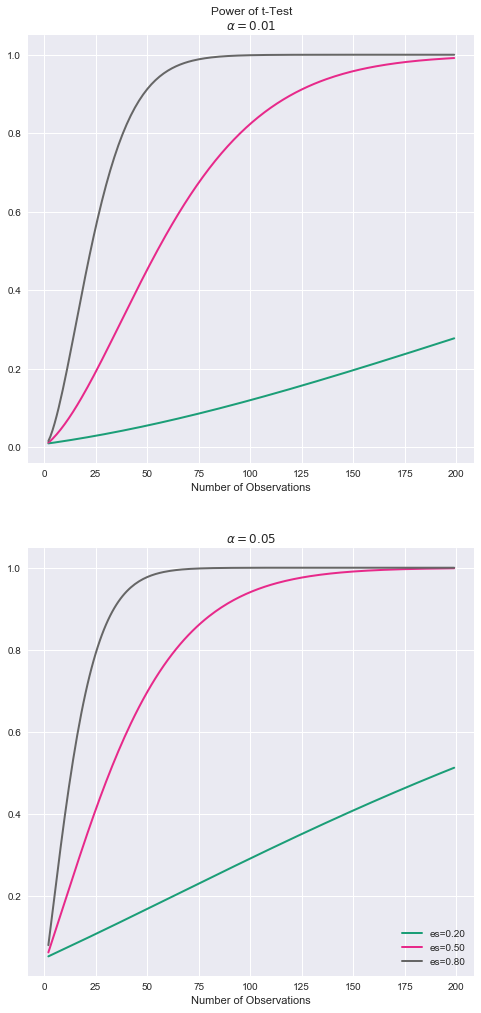

In [28]:
plt.style.use('seaborn')
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.01,
                                 ax=ax, title='Power of t-Test' + '\n' + r'$\alpha = 0.01$')
ax.get_legend().remove()
ax = fig.add_subplot(2,1,2)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.05,
                                 ax=ax, title=r'$\alpha = 0.05$') 
fig.subplots_adjust(top = 2.5)

## Run a PDSLasso

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
df.isnull().sum()

Age                     0
Fruit                   0
Vegetable               0
Red meat                0
Fish                    0
Egg                     0
Snacks                  0
Junk                    0
Ready to eat/drink      0
Alcohol                 0
Subjective health       3
Contains plastic        4
Chocolate box?          0
Optimistic              0
Level of concern       10
Longevity insurance     0
Cash inflow             5
Male                    0
Healthy                 0
dtype: int64

In [31]:
df.fillna(df.median(), inplace=True)

In [32]:
df.isnull().sum()

Age                    0
Fruit                  0
Vegetable              0
Red meat               0
Fish                   0
Egg                    0
Snacks                 0
Junk                   0
Ready to eat/drink     0
Alcohol                0
Subjective health      0
Contains plastic       0
Chocolate box?         0
Optimistic             0
Level of concern       0
Longevity insurance    0
Cash inflow            0
Male                   0
Healthy                0
dtype: int64

In [33]:
df.head(5)

,Age,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Subjective health,Contains plastic,Chocolate box?,Optimistic,Level of concern,Longevity insurance,Cash inflow,Male,Healthy
0,1,4,2,5,4,5,5,1,1,3,4.0,2.0,1,1,5.0,0,1500.0,0,0
1,1,5,5,3,2,2,1,1,2,1,5.0,3.0,1,1,5.0,1,700.0,1,0
2,1,5,4,3,4,1,1,1,2,1,4.0,1.0,1,0,3.0,1,0.0,0,0
3,2,5,4,4,2,5,5,3,3,3,3.0,3.0,1,1,4.0,0,6000.0,1,0
4,1,2,2,3,2,3,2,2,2,5,3.0,3.0,1,0,4.0,0,0.0,0,0


### Standardize at first

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [35]:
to_standardize = ['Age', 'Fruit', 'Vegetable', 'Red meat', 'Fish', 'Egg', 'Snacks', 'Junk', 'Ready to eat/drink',
                    'Alcohol', 'Subjective health', 'Contains plastic', 'Level of concern', 'Cash inflow']
not_to_standardize = list(set(list(df.columns.values)) - set(to_standardize))
not_to_standardize

['Optimistic', 'Longevity insurance', 'Chocolate box?', 'Male', 'Healthy']

In [36]:
mm = MinMaxScaler()
df_std = pd.concat([pd.DataFrame(mm.fit_transform(df[to_standardize]), columns = to_standardize, index=df.index), df[not_to_standardize]], axis=1)

C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [37]:
df_std.head(5)

,Age,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Subjective health,Contains plastic,Level of concern,Cash inflow,Optimistic,Longevity insurance,Chocolate box?,Male,Healthy
0,0.142857,0.75,0.25,1.00,0.75,1.00,1.00,0.00,0.00,0.5,0.75,0.25,1.00,0.15,1,0,1,0,0
1,0.142857,1.00,1.00,0.50,0.25,0.25,0.00,0.00,0.25,0.0,1.00,0.50,1.00,0.07,1,1,1,1,0
2,0.142857,1.00,0.75,0.50,0.75,0.00,0.00,0.00,0.25,0.0,0.75,0.00,0.50,0.00,0,1,1,0,0
3,0.285714,1.00,0.75,0.75,0.25,1.00,1.00,0.50,0.50,0.5,0.50,0.50,0.75,0.60,1,0,1,1,0
4,0.142857,0.25,0.25,0.50,0.25,0.50,0.25,0.25,0.25,1.0,0.50,0.50,0.75,0.00,0,0,1,0,0


### Combine Longevity insurance with Level of concern, Optimism and "Chocolate box"

In [38]:
df['Longevity insurance'] = np.squeeze(mm.fit_transform(np.array(df['Longevity insurance'] + df['Optimistic'] * 0.2 + df['Chocolate box?'] * 0.2 - df['Level of concern'] * 0.2).reshape(-1, 1)))

In [39]:
X = df.drop(['Longevity insurance', 'Optimistic', 'Chocolate box?', 'Level of concern'], axis=1)
y = df['Longevity insurance']

## First step

### Lasso of Longevity insurance on controls

In [40]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

lasso = Lasso(0.07, random_state=0)
lasso.fit(X, y)
lasso.coef_

array([ 0.00000000e+00,  0.00000000e+00,  1.62717695e-02, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -1.62250740e-04,  0.00000000e+00, -0.00000000e+00,
       -2.17861226e-05, -0.00000000e+00,  0.00000000e+00])

In [41]:
first = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso.coef_})
first

,Variable,Coefficient
0,Age,0.000000
1,Fruit,0.000000
2,Vegetable,0.016272
3,Red meat,-0.000000
4,Fish,0.000000
5,Egg,-0.000000
6,Snacks,-0.000000
7,Junk,-0.000000
8,Ready to eat/drink,-0.000000
9,Alcohol,-0.000162


In [42]:
print(first['Variable'][first['Coefficient'] != 0])

2       Vegetable
9         Alcohol
12    Cash inflow
Name: Variable, dtype: object


## Second step

### Lasso of Healthy on controls

In [43]:
df.columns.values

array(['Age', 'Fruit', 'Vegetable', 'Red meat', 'Fish', 'Egg', 'Snacks',
       'Junk', 'Ready to eat/drink', 'Alcohol', 'Subjective health',
       'Contains plastic', 'Chocolate box?', 'Optimistic',
       'Level of concern', 'Longevity insurance', 'Cash inflow', 'Male',
       'Healthy'], dtype=object)

In [44]:
y = df['Healthy']
X = X.drop(['Healthy'], axis=1)

In [45]:
lasso = Lasso(0.5, random_state=0)
lasso.fit(X, y)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)

In [46]:
second = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso.coef_})
second

,Variable,Coefficient
0,Age,-0.000000
1,Fruit,0.000000
2,Vegetable,0.000000
3,Red meat,-0.000000
4,Fish,0.000000
5,Egg,0.000000
6,Snacks,-0.000000
7,Junk,-0.000000
8,Ready to eat/drink,-0.000000
9,Alcohol,-0.000000


In [47]:
print(second['Variable'][second['Coefficient'] != 0])

12    Cash inflow
Name: Variable, dtype: object


## Final step

### LPM on the union of the regressor

In [48]:
from sklearn.linear_model import LinearRegression

In [49]:
lr = LinearRegression()
X = df[['Vegetable', 'Cash inflow', 'Alcohol', 'Healthy']]
y = df['Longevity insurance']
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [50]:
final = pd.DataFrame({'Variable': X.columns, 'Coefficient': lr.coef_})
final

,Variable,Coefficient
0,Vegetable,0.046043
1,Cash inflow,-0.000021
2,Alcohol,-0.022408
3,Healthy,0.041671


In [51]:
customer_persona = pd.DataFrame({'Category': list(df.columns.values), 
              'Mean value among those buying insurance' : [np.mean(df[cat][df['Longevity insurance'] > 0.8]) for cat in list(df.columns.values)]
                                                                     })
customer_persona.to_csv("C:/Users/Pc_User/Desktop/H-Farm/customer_persona.csv")
customer_persona

,Category,Mean value among those buying insurance
0,Age,1.80
1,Fruit,4.20
2,Vegetable,4.40
3,Red meat,3.00
4,Fish,3.00
5,Egg,2.60
6,Snacks,2.60
7,Junk,1.40
8,Ready to eat/drink,1.80
9,Alcohol,2.60


## Instrumental variables

### We realize that in our dataset we have collected variables which could work as instrumental variables, that could mitigate the omitted variable bias. For instance, all food categories are correlated with Longevity Insurance (relevance) and can impact it only through our main X (healthy). To verify this ask yourself, if you were to observe that an individual, when he eats more fruit, his propensity to buy longevity insurance increases (like is observed here), can you think of another reason other than he is healthier? 

### However, to reduce omitted variable bias, you have to make an assumption on the other hand, that the level of health of people is the same of what respondents say it is (which is what you assume anyway by only using a survey in the first place)

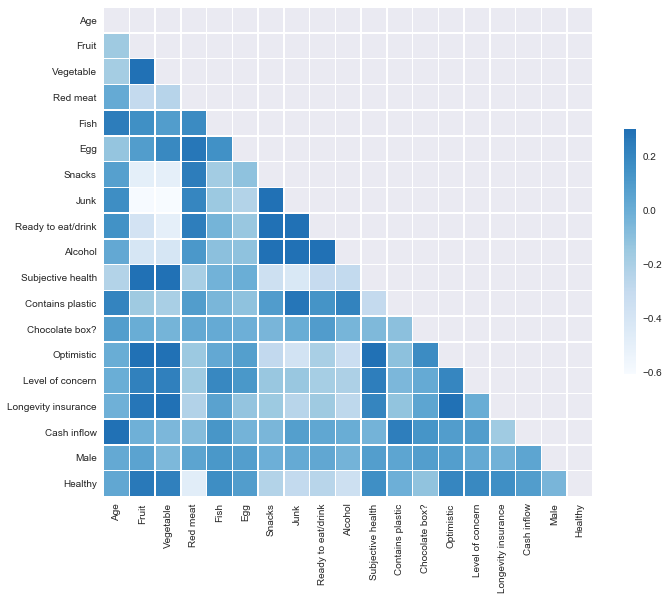

In [52]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, cmap='Blues', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [53]:
df.corrwith(df['Subjective health'])

Age                   -0.229342
Fruit                  0.394450
Vegetable              0.356636
Red meat              -0.194348
Fish                  -0.019701
Egg                    0.002069
Snacks                -0.351132
Junk                  -0.423967
Ready to eat/drink    -0.298393
Alcohol               -0.294518
Subjective health      1.000000
Contains plastic      -0.296032
Chocolate box?        -0.058662
Optimistic             0.317072
Level of concern       0.240327
Longevity insurance    0.209078
Cash inflow           -0.025838
Male                   0.087109
Healthy                0.159844
dtype: float64

In [54]:
x = df['Subjective health']
y = df['Longevity insurance']
z = df['Fruit']

### Relevance

In [55]:
relevance = LinearRegression()
relevance.fit(np.array(z).reshape(-1, 1), np.array(x).reshape(-1, 1))
coefficient = list(relevance.coef_[0])[0]
coefficient

0.27775340061430437

### T-test

In [56]:
sigma_squared = np.sum((x - z * coefficient)**2) / (len(df) - 2)
sigma_squared

6.5777962391340425

In [57]:
standard_error = sigma_squared / np.dot(np.array(z), np.array(z))
standard_error

0.0036421906086013525

In [58]:
statistics = coefficient / standard_error
statistics

76.25998484493518

In [65]:
from scipy.stats import t
p_value = (1 - t.cdf(statistics, len(df) - 2)) * 2
print(p_value)
print('RELEVANT!')

0.0
RELEVANT!


### Calculate the Beta IV

In [60]:
np.dot(z, y) / np.dot(z, x) 

0.14902088772845953

## Plot customer persona characteristics

In [61]:
categories = ['Fruit','Vegetable','Red meat','Fish','Egg','Snacks','Junk','Ready to eat/drink','Alcohol','Contains plastic']
plot = np.array(df[df['Longevity insurance'] > 0.8][categories]).reshape(-1, 1).reshape(-1)
a = np.array([categories[0]] * len(df[df['Longevity insurance'] > 0.8])).reshape(-1, 1)
for cat in categories[1:]:
    a = np.vstack((a, np.array([cat] * len(df[df['Longevity insurance'] > 0.8])).reshape(-1, 1)))
a = a.reshape(-1)
df_plot = pd.DataFrame({'Values':plot, 'Index': a})
df_plot.head(5)

,Values,Index
0,5.0,Fruit
1,4.0,Fruit
2,3.0,Fruit
3,3.0,Fruit
4,2.0,Fruit


C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


(<Figure size 576x396 with 11 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1bfe85c2278>])

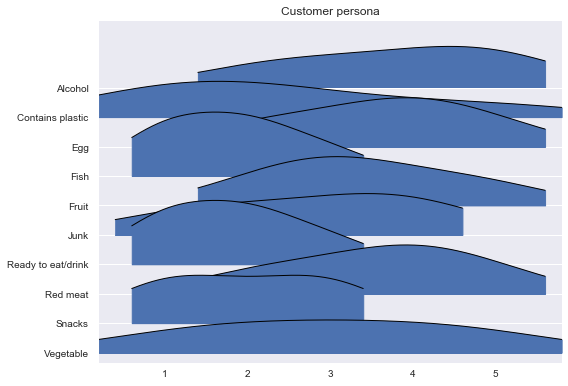

In [62]:
import joypy
fig, ax = plt.subplots(1,2)
joypy.joyplot(df_plot, by="Index", column="Values", range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title=f"Customer persona", ax=ax[0])